# Project 3 
### Iris segmentation and feature extraction
Jack Sandberg 
<br>
Sara Arnesen
<br>
David Nordström


###### Spring 2022

### Sources
##### Valuable resources

Daugman's algorithm in Python: https://github.com/banderlog/daugman
<br>
MMU Data set analyzed with TensorFlow: https://github.com/emrealtann/IrisRecognition 
<br>
Hough transform and iris normalization: https://github.com/akshatapatel/Iris-Recognition 

In [ ]:
!apt update
!apt install ffmpeg libsm6 libxext6 -y
!pip install opencv-python
!pip install --upgrade pip
!pip install scikit-image

Hit:1 http://security.debian.org/debian-security buster/updates InRelease
Hit:2 http://deb.debian.org/debian buster InRelease
Hit:3 http://deb.debian.org/debian buster-updates InRelease



32 packages can be upgraded. Run 'apt list --upgradable' to see them.



libsm6 is already the newest version (2:1.2.3-1).
libxext6 is already the newest version (2:1.3.3-1+b2).
ffmpeg is already the newest version (7:4.1.9-0+deb10u1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [2]:
# Imported libraries 

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt # Plotting
import numpy as np # Linear Algebra
import os # Accessing directory structure
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)
from math import ceil, floor
import cv2
import itertools
import math
from typing import Tuple, List
import glob
from scipy.spatial import distance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import metrics


### Brief summary the notebook's content

This project will comprise two stages of iris recognition algorithm:

1. Image Preprocessing
2. Feature Extraction

#### 1. Image preprocessing
Image preprocessing is further divided into three steps:

1. Iris localization
2. Iris normalization
3. Image enhancement

Two different algorithms will be used for the localization of the iris: **Integro-differential operator** and **Hough transform**. 

Furthermore, to detect the eyelashes in the image Gabor filter and variance of intensity approaches will be used. 

For the iris normalization the homogenous rubber sheet model will be use in order to convert the Cartesian coordinates in the image to polar coordinates. The non-centric polar representation will be normalized to a fixed size rectangular block, which aims to depict the iris segment of the eye image.

#### 2. Feature extraction



### Paths for the MMU-Iris-Database


In [ ]:
path = '/work/MMU-Iris-Database/5/left/chongpkl4.bmp' # Non-occluded eye
path = '/work/MMU-Iris-Database/29/left/pcll2.bmp' # Non-occluded eye
path = '/work/MMU-Iris-Database/1/left/aeval1.bmp' # 
path = '/work/MMU-Iris-Database/2/left/bryanl1.bmp' # 
#path = '/work/MMU-Iris-Database/13/left/lec_1.bmp' # Eye far down - outlier?
#path = '/work/MMU-Iris-Database/20/left/masl1.bmp' # Eye fairly occluded
#path = '/work/MMU-Iris-Database/20/left/masl2.bmp' # Eye far right - outlier?

exampleImage = Image.open(path)
exampleArray = np.array(exampleImage)
print(exampleArray.shape)

(240, 320, 3)


In [1]:
exampleArray[:,:,0]

NameError: name 'exampleArray' is not defined

Example of image from the MMU-Iris-Database

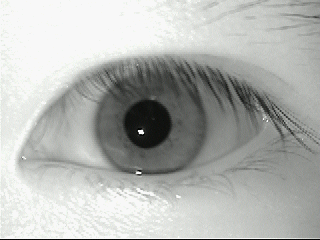

In [ ]:
exampleImage

### Image preprocessing: Iris Localization
#### Integro-differential operator

The code for the integro-differential operator was provided by: https://github.com/banderlog/daugman/blob/master/daugman.py

The integro-differential operator is used to approximate inner and outer boundaries of iris and upper and lower eyelids and was first presented by John Daugman:

$\max_{r, x_0, y_0} \left|G_{\sigma(r) * \frac{\partial}{\partial}}\int_{(r, x_o, y_o)} \frac{I(x,y)}{2 \pi r}ds \right|$

$I(x,y)$ is an image containing an eye. The operator will search over the image domain (x,y) for the maximum in the blurred partial derivative with respect to increasing radius r, of the normalized contour integral of along a
circular arc of radius and center coordinates $x_0, y_0$. $G_\sigma(r)$ is a smoothing such as a Gaussian of scale $\sigma$.

In [3]:
# From https://github.com/banderlog/daugman/blob/master/daugman.py

def daugman(gray_img: np.ndarray, center: Tuple[int, int], start_r: int, end_r: int, step: int = 1) -> Tuple[float, int]:

    """ The function will calculate pixel intensities for the circles
        in the range(start_r, end_r, step) for a given center,
        and find a circle that precedes the biggest intensity drop
        :param gray_img: grayscale picture
        :param center:  center coordinates (x, y)
        :param start_r: bottom value for iris radius in pixels
        :param end_r: top value for iris radius in pixels
        :param step: step value for iris radii range in pixels
    
         Input grayscale image should be a square, not a rectangle
        :return: intensity_value, radius
    """
    x, y = center
    intensities = []
    mask = np.zeros_like(gray_img)

    # For every radius in range
    radii = list(range(start_r, end_r, step))
    for r in radii:
        # Draw circle on mask
        cv2.circle(mask, center, r, 255, 1)
        # Get pixel from original image
        diff = gray_img & mask
        # Normalization
        intensities.append(np.add.reduce(diff[diff > 0]) / (2 * math.pi * r))
        # Refresh mask
        mask.fill(0)

    # Calculate delta of radius intensitiveness
    intensities_np = np.array(intensities, dtype=np.float32)
    del intensities

    # Circles intensity differences
    intensities_np = intensities_np[:-1] - intensities_np[1:]
    # Apply gaussian filter
    # The Gaussian filter is designed in MATLAB and is a 1 by 5 (rows by columns) vector with intensity values
    # given by vector A = [0.0003 0.1065 0.7866 0.1065 0.0003]

    intensities_np = abs(cv2.GaussianBlur(intensities_np, (1, 5), 0))
    # Get maximum value
    idx = np.argmax(intensities_np)

    # Return intensity value, radius
    return intensities_np[idx], radii[idx]


def find_iris(gray: np.ndarray, *,
              daugman_start: int, daugman_end: int,
              daugman_step: int = 1, points_step: int = 1,) -> Tuple[Tuple[int, int], int]:
    
    """ The function will apply :func:daugman on every pixel in the calculated image slice.
        It is assumed that iris center lies within central 1/3 of the image.
        :param gray: grayscale square image
        :param points_step: it will run daugman for each points_step point.
                            It has linear correlation with overall iris search speed
        :param daugman_start: bottom value for iris radius in pixels for :func:daugman
        :param daugman_end: top value for iris radius in pixels for :func:daugman
        :param daugman_step: step value for iris radii range in pixels for :func:daugman
                             It has linear correlation with overall iris search speed
        :return: radius with biggest intensiveness delta on image as ``((xc, yc), radius)``
    """
    
    h, w = gray.shape
    if h != w:
        print('Your image is not a square!')

    # Reduce step for better accuracy
    # We will look only on dots within central 1/3 of image
    single_axis_range = range(int(h / 3), h - int(h / 3), points_step)
    all_points = itertools.product(single_axis_range, single_axis_range)

    intensity_values = []
    coords = []  # List[Tuple[Tuple(int, int), int]]

    for point in all_points:
        val, r = daugman(gray, point, daugman_start, daugman_end, daugman_step)
        intensity_values.append(val)
        coords.append((point, r))

    # return the radius with biggest intensiveness delta on image
    # ((xc, yc), radius)
    best_idx = intensity_values.index(max(intensity_values))
    return coords[best_idx]

##### Converting to grayscale

The image is converted to grayscale, and the size is saved into variables h and w. The image is thereafter shown.

(240, 320)


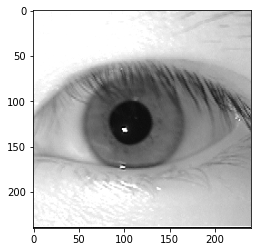

In [ ]:
gray_img = cv2.cvtColor(exampleArray, cv2.COLOR_BGR2GRAY)
print(gray_img.shape)

h,w = gray_img.shape

gray_img = gray_img[:,(w - h)//2:(w + h)//2]
_ = plt.imshow(gray_img, cmap='gray')

##### Finding the outer lineation of the iris

The outer part of the iris is found by using the integro-differential operator.

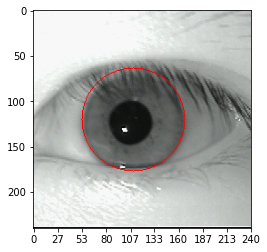

In [ ]:
outer_boundary = find_iris(gray_img, daugman_start=35, daugman_end=80, daugman_step=1, points_step=2)
iris_center, iris_rad = outer_boundary

# Plotting the result
out = exampleArray.copy()[:,(w - h)//2:(w + h)//2,:]
cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
_ = plt.imshow(out[::,::,::-1])
plt.xticks(np.round(np.linspace(0,out.shape[1],10)))
print()

##### Pupil localization

According to Daguman the pupil center is nasal and inferior to the iris center. Its radius can range from 0.1 to 0.8 of the iris radius. Thus, all three parameters defining the pupillary circle must be estimated separately from those of the iris. Similar for the iris localizaation the integrodifferential operator as follows will be used: 

$\max_{(r, x_0, y_0)} \left| G_\sigma (r) * \frac{\partial}{\partial r} \oint_{r, x_0, y_0} \frac{I(x,y)}{2\pi r} ds \right| $

However, firstly one must crop the image in order to do pupil localization.

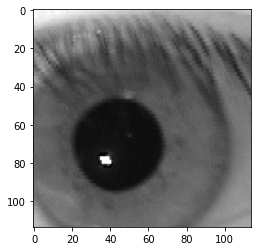

In [ ]:
# Cropping the image to reduce the search area 

pupil_crop = gray_img[(iris_center[0] - iris_rad):(iris_center[0] + iris_rad), 
    (iris_center[1]-iris_rad):(iris_center[1] + iris_rad)]
plt.imshow(pupil_crop, cmap='gray')

In [ ]:
# Using integro-differential operator 

pupil_localization = find_iris(pupil_crop, daugman_start=round(0.3*iris_rad), daugman_end=round(0.8*iris_rad), daugman_step=1, points_step=2)
pupil_center, pupil_rad = pupil_localization

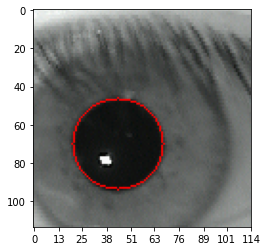

In [ ]:
# Plotting the results 

out = exampleArray.copy()[:,(w - h)//2:(w + h)//2,:]
out = out[(iris_center[0] - iris_rad):(iris_center[0] + iris_rad), 
    (iris_center[1]-iris_rad):(iris_center[1] + iris_rad), :]

cv2.circle(out, pupil_center, pupil_rad, (0, 0, 255), 1)
_ = plt.imshow(out[::,::,::-1])
plt.xticks(np.round(np.linspace(0,out.shape[1],10)))
print()

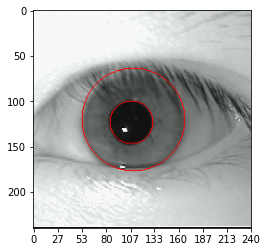

In [ ]:
# Plotting the result

out = exampleArray.copy()[:,(w - h)//2:(w + h)//2,:]

cv2.circle(out, (pupil_center[0]+64,pupil_center[1]+53), pupil_rad, (0, 0, 255), 1)

cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)

_ = plt.imshow(out[::,::,::-1])

plt.xticks(np.round(np.linspace(0,out.shape[1],10)))
print()



### Image preprocessing: Iris Localization
#### Hough Transformation

The Hough transform has seen wide use in iris segmentation. Similar to Daugman's method, the Hough transform is also based on the first derivative of the image intensity. Wildes used the method by first obtaining an edge map of the image by thresholding the magnitude of the image intensity gradient.

$\left|\nabla G(x,y)I(x,y)\right|$

Where $G(x,y)$ is a Gaussian smoothing function, with parameters chosen to facilitate edge analysis. A voting process is the then initiated based on the edge map to maximise the defined Hough transform for the desired contour. In the Hough space, a maximum point will correspond to the radius $r_c$ and centre coordinates $x_c$ and $y_c$ of a circle defined by the edge points obeying the following equation.

$x_c^2+y_c^2=r_c^2$

#img = cv2.imread('/work/MMU-Iris-Database/2/left/bryanl1.bmp',0)
#cv2.imshow('detected circles',img)

'''
exampleImage = Image.open(path)
data = np.array(exampleImage)
print(data)


info = np.iinfo(data.dtype)
data = data.astype(np.float64) / info.max # normalize the data to 0 - 1
data = 255 * data # Now scale by 255
img = data.astype(np.uint8)

img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT,1,20,param1=50,param2=30,minRadius=35,maxRadius=80)
                            
circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
cv2.imshow('detected circles',cimg)
'''


## Iris normalization

Code provided by: https://github.com/akshatapatel/Iris-Recognition/blob/master/IrisNormalization.py 

In [ ]:
def IrisNormalization(boundary,centers, iris_radius):
    target = [img for img in boundary]
    normalized=[]
    cent=0
    for img in target:
        #load pupil centers and radius of inner circles
        center_x = centers[cent][0]
        center_y = centers[cent][1]
        radius_pupil=int(centers[cent][2])
        
        #iris_radius = 53 # width of space between inner and outer boundary
    
        #define equally spaced interval to iterate over
        nsamples = 360
        samples = np.linspace(0,2*np.pi, nsamples)[:-1]
        polar = np.zeros((iris_radius, nsamples))
        for r in range(iris_radius):
            for theta in samples:
                #get x and y for values on inner boundary
                x = (r+radius_pupil)*np.cos(theta)+center_x
                y = (r+radius_pupil)*np.sin(theta)+center_y
                x=int(x)
                y=int(y)
                try:
                #convert coordinates
                    polar[r][int((theta*nsamples)/(2*np.pi))] = img[y][x]
                except IndexError: #ignores values which lie out of bounds
                    pass
                continue
        res = cv2.resize(polar,(512,64))
        normalized.append(res)
        cent+=1
    return normalized #returns a list of 64x512 normalized images

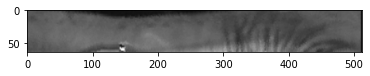

In [ ]:
normalized = IrisNormalization([gray_img], [[*iris_center, pupil_rad]], iris_rad-pupil_rad)[0]
plt.imshow(normalized, cmap = 'gray')


## Feature extraction

In [ ]:
def GaborWavelet(R, C, Kmax, f, u, v, Delta):
    k = (Kmax / (f**v)) * np.exp(1j * u * np.pi / 8) # Wave vector
    kn2 = np.abs(k)**2

    GW = np.zeros((R,C))
    for m in range(int(-R/2 + 1), int(R/2)):
        for n in range(int(-C/2 + 1), int(C/2)):
            GW[int(m + R/2), int(n + C/2)] = (kn2 / Delta) * np.exp(-0.5 * kn2 * (m**2 + n**2) / Delta)*(np.exp(1j * (k.real * m + k.imag * n)) - np.exp(-0.5 * Delta))
    
    return GW

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


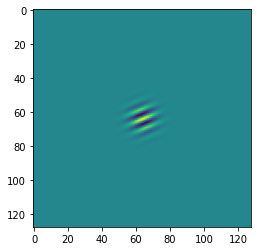

In [ ]:
# Parameter Setting
R = 128
C = 128
Kmax = np.pi/ 2
f = np.sqrt( 2 )
Delt = 2 * np.pi
Delta = Delt * Delt

# Show the Gabor Wavelets
GW = GaborWavelet(R, C, Kmax, f, 1, 1, Delta)
plt.imshow(GW.real)


In [ ]:
z,t = np.shape(np.zeros((3,3)))
print(z)

3


In [ ]:
from scipy import ndimage
import math
import numpy as np


def defined_filter(x, y, f):
    m1 = math.cos(2 * math.pi * f * math.sqrt(x ** 2 * y ** 2))
    return m1

space_constant_x1 = 3
space_constant_x2 = 4.5
space_constant_y = 1.5

f1 = 0.1
f2 = 0.07
x1 = range(-9, 10, 1)
x2 = range(-14, 15, 1)
y = range(-5, 6, 1)


def gabor_filter(x, y, space_constant_x, space_constant_y, f):
    m1 = defined_filter(x, y, f)
    return (1 / (2 * math.pi * space_constant_x * space_constant_y)
            * np.exp(-1 / 2 * (x ** 2 / (space_constant_x ** 2) + y ** 2 / (space_constant_y ** 2)))) * m1


def FeatureExtraction(roi):
    filter1 = []
    filter2 = []
    f1 = 0.1
    f2 = 0.07

    x1 = range(-9, 10, 1)
    x2 = range(-14, 15, 1)
    y = range(-5, 6, 1)

    space_constant_x1 = 3
    space_constant_x2 = 4.5
    space_constant_y = 1.5

    for j in range(len(y)):
        for i in range(len(x1)):
            cell_1 = gabor_filter(x1[i], y[j], space_constant_x1, space_constant_y, f1)
            filter1.append(cell_1)
        for k in range(len(x2)):
            cell_2 = gabor_filter(x2[k], y[j], space_constant_x2, space_constant_y, f2)
            filter2.append(cell_2)
    filter1 = np.reshape(filter1, (len(y), len(x1)))
    filter2 = np.reshape(filter2, (len(y), len(x2)))

    filtered_eye1 = ndimage.convolve(roi, np.real(filter1), mode='wrap', cval=0)
    filtered_eye2 = ndimage.convolve(roi, np.real(filter2), mode='wrap', cval=0)

    vector = []
    i = 0
    while i < roi.shape[0]:
        j = 0
        while j < roi.shape[1]:
            mean1 = filtered_eye1[i:i + 8, j:j + 8].mean()
            mean2 = filtered_eye2[i:i + 8, j:j + 8].mean()
            AAD1 = abs(filtered_eye1[i:i + 8, j:j + 8] - mean1).mean()
            AAD2 = abs(filtered_eye2[i:i + 8, j:j + 8] - mean2).mean()

            vector.append(mean1)
            vector.append(AAD1)
            vector.append(mean2)
            vector.append(AAD2)
            j = j + 8
        i = i + 8
    vector = np.array(vector)
    return vector, filtered_eye1, filtered_eye2

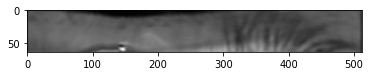

In [ ]:
vector, filtered_eye1, filtered_eye2 = FeatureExtraction(normalized)

plt.imshow(filtered_eye2, cmap = 'gray')

In [ ]:
from scipy.signal import convolve2d

def GaborFunc(r, theta, omega = 1, alpha = 1, beta = 1):
    return r * np.exp(-1j * omega * theta - (r/alpha)**2 - (theta/beta)**2)
    
def GaborArray(Rho, Phi, omega = 1, alpha = 1, beta = 1):
    return np.array([[GaborFunc(rho, phi, omega, alpha, beta) for phi in Phi] for rho in Rho])
    
def GaborBit(img, radius, r0 = 0, theta0 = 0, omega = 1, alpha = 1, beta = 1):
    Rho = r0 - np.linspace(0, 1, img.shape[0])
    Phi = theta0 - np.linspace(0, 2 * np.pi, img.shape[1])
    gaborwave = GaborArray(Rho, Phi, omega, alpha, beta)
    return np.sum(img * gaborwave)
    #return convolve2d(img, gaborwave)

def ComputeGaborBits(img, iris_rad, pupil_rad, N = [4, 4, 4]):
    alphas = np.linspace(0.15, 1.2, N[0])
    betas = np.linspace(0.15, 1.2, N[1])
    omegas = np.logspace(1, 3, N[1], base = 2.0) / betas
    gaborVals = np.zeros(N, dtype = complex)
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            for k, omega in enumerate(omegas):
                gaborVals[i,j,k] = GaborBit(img, iris_rad - pupil_rad, r0 = pupil_rad/iris_rad, alpha = alpha, beta = beta, omega = omega)
    gaborBitsReal = np.maximum(np.sign(gaborVals.real), 0)
    gaborBitsImag = np.maximum(np.sign(gaborVals.imag), 0)
    return np.stack([gaborBitsReal, gaborBitsImag], axis = -1)
gaborBits = ComputeGaborBits(normalized, iris_rad, pupil_rad)


In [ ]:
gaborBits.shape

(4, 4, 4, 2)

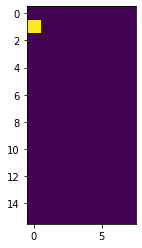

In [ ]:
plt.imshow(gaborBits.reshape(gaborBits.shape[0] * gaborBits.shape[1], gaborBits.shape[2] * gaborBits.shape[3]))

Code from: https://github.com/akshatapatel/Iris-Recognition 

In [ ]:
# Calculating the hamming distance

def hamming_distance(x, y):
    return np.sum(np.abs(np.subtract(x, y)))

In [ ]:
import cv2
import numpy as np
import glob
import math
from scipy.spatial import distance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

#Equalizes the histogram of the image
def ImageEnhancement(normalized):
    enhanced=[]
    for res in normalized:
        res = res.astype(np.uint8)
        im=cv2.equalizeHist(res)
        enhanced.append(im)
    return enhanced

In [ ]:
import cv2
import numpy as np
import glob
import math
import scipy
from scipy.spatial import distance
from scipy import signal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


#modulating function as defined in paper
def m(x ,y, f):
    val = np.cos(2*np.pi*f*math.sqrt(x **2 + y**2))
    return val
#spatial filter as defined in paper
def gabor(x, y, dx, dy, f):
    gb = (1/(2*math.pi*dx*dy))*np.exp(-0.5*(x**2 / dx**2 + y**2 / dy**2)) * m(x, y, f)
    return gb

#function to calculate spatial filter over 8x8 blocks
def spatial(f,dx,dy):
    sfilter=np.zeros((8,8))
    for i in range(8):
        for j in range(8):
            sfilter[i,j]=gabor((-4+j),(-4+i),dx,dy,f)
    return sfilter

def get_vec(convolvedtrain1,convolvedtrain2):
    feature_vec=[]
    for i in range(6):
            for j in range(1):
                #Run 8 by 8 filtered block iteratively over the entire image
                start_height = i*8
                end_height = start_height+8
                start_wid = j*8
                end_wid = start_wid+8
                grid1 = convolvedtrain1[start_height:end_height, start_wid:end_wid]
                grid2 = convolvedtrain2[start_height:end_height, start_wid:end_wid]

                # Channel 1
                absolute = np.absolute(grid1)
                # mean
                mean = np.mean(absolute)
                feature_vec.append(mean)
                #deviation
                std = np.mean(np.absolute(absolute-mean))
                feature_vec.append(std)

                # Channel 2
                absolute = np.absolute(grid2)
                # mean
                mean = np.mean(absolute)
                feature_vec.append(mean)
                #deviation
                std = np.mean(np.absolute(absolute-mean))
                feature_vec.append(std)

    return feature_vec

def FeatureExtraction(enhanced):
    con1=[]
    con2=[]
    #get spatial filters
    filter1=spatial(0.67,3,1.5)
    filter2=spatial(0.67,4,1.5) 
    
    feature_vector=[]
    
    for i in range(len(enhanced)):
        img=enhanced[i]
        #define a 48x512 region over which the filters are applied
        img_roi=img[:48,:]        
        filtered1=scipy.signal.convolve2d(img_roi,filter1,mode='same')
        filtered2=scipy.signal.convolve2d(img_roi,filter2,mode='same')
        
        con1.append(filtered1)
        con2.append(filtered2)
        fv=get_vec(filtered1,filtered2)
        feature_vector.append(fv)
    return feature_vector #each feature vector has a dimension of 1536

In [ ]:
import cv2
import numpy as np
import glob
import math
from scipy.spatial import distance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

def dim_reduction(feature_vector_train,feature_vector_test,components):
    '''TRAINING'''
    ft_train=feature_vector_train
    
    #get the classes of all training feature vectors
    y_train=[]
    for i in range(0,108):
        for k in range(0,3):
            y_train.append(i+1)
    y_train=np.array(y_train)
    
    #fit the LDA model on training data with n components
    sklearn_lda = LDA(n_components=components)
    sklearn_lda.fit(ft_train,y_train)
    
    #transform the traning data
    red_train=sklearn_lda.transform(ft_train)
    
    '''TESTING'''
    ft_test=feature_vector_test
    
    #transform the testing data
    red_test=sklearn_lda.transform(ft_test)
    
    
    #get a list of predicted values for the testing data to calculate ROC
    y_pred=sklearn_lda.predict(ft_test)
    
    #return transformed training and testing data, and the testing classes and predicted values for ROC
    return red_train,red_test


def IrisMatching(feature_vector_train,feature_vector_test,components,flag):
    
    #if flag is 1, we do not need to reduce dimesionality otherwise we call the dim_reduction function
    if flag==1:
        red_train=feature_vector_train
        red_test=feature_vector_test
        
    elif flag==0:
        red_train,red_test=dim_reduction(feature_vector_train,feature_vector_test,components)


    arr_f=red_test #test
    arr_fi=red_train #train
    
    index_L1=[]
    index_L2=[]
    index_cosine=[]
    min_cosine=[]
    
    #this loop iterates over each test image
    for i in range(0,len(arr_f)):
        L1=[]
        L2=[]
        Cosine=[]
        
        #this loop iterates over every training image - to be compared to each test image
        for j in range(0,len(arr_fi)):
            f=arr_f[i]
            fi=arr_fi[j]
            sumL1=0 #L1 distance
            sumL2=0 #L2 distance
            sumcos1=0
            sumcos2=0
            cosinedist=0 #cosine distance
            
            #calculate L1 and L2 using the formulas in the paper
            for l in range(0,len(f)):
                sumL1+=abs(f[l]-fi[l])
                sumL2+=math.pow((f[l]-fi[l]),2)
            
            
            #calculate sum of squares of all features for cosine distance
            for k in range(0,len(f)):
                sumcos1+=math.pow(f[k],2)
                sumcos2+=math.pow(fi[k],2)
                
            
            #calculate cosine distance using sumcos1 and sumcos2 calculated above
            cosinedist=1-((np.matmul(np.transpose(f),fi))/(math.pow(sumcos1,0.5)*math.pow(sumcos2,0.5)))
            
            L1.append(sumL1)
            L2.append(sumL2)
            Cosine.append(cosinedist)
        #get minimum values for L1 L2 and cosine distance for each test image and store their index
        index_L1.append(L1.index(min(L1)))
        index_L2.append(L2.index(min(L2)))
        index_cosine.append(Cosine.index(min(Cosine)))
        min_cosine.append(min(Cosine))
        
    match=0
    count=0
    
    #stores final matching - correct(1) or incorrect (0)
    match_L1=[]
    match_L2=[]
    match_cosine=[]
    match_cosine_ROC=[]
    
    #calculating matching of the test set according to the ROC thresholds
    thresh=[0.4,0.5,0.6]
    
    for x in range(0,len(thresh)):
        match_ROC=[]
        for y in range(0,len(min_cosine)):
            if min_cosine[y]<=thresh[x]:
                match_ROC.append(1)
            else:
                match_ROC.append(0)
        match_cosine_ROC.append(match_ROC)
        
    
    for k in range(0,len(index_L1)):
        '''count goes from 0 to 3 because we compare the indexes obtained for the first 4 images of the test data
        to the indexes of the first 3 images of 
        the train data (for which match is incremented by 3 everytime count exceeds the value of 3)'''
        if count<4:
            count+=1
        else:
            match+=3
            count=1
            
        '''check if matching is done correctly (1) or not (0) for L1 L2 and cosine distance and accordingly update
        the arrays match_L1,match_L2,match_cosine'''
        if index_L1[k] in range(match,match+3):
                match_L1.append(1)
        else:
            match_L1.append(0)
        if index_L2[k] in range(match,match+3):
            match_L2.append(1)
        else:
            match_L2.append(0)
        if index_cosine[k] in range(match,match+3):
            match_cosine.append(1)
        else:
            match_cosine.append(0)
    #reuturns the matching arrays, and test calsses and predicted values to calculate ROC
    return match_L1,match_L2,match_cosine,match_cosine_ROC

In [ ]:
feature_vector_train=feature_vector
feature_vector_test=feature_vector
match_L1,match_L2,match_cosine,match_cosine_ROC=IrisMatching(feature_vector_train,feature_vector_test,107,1)
match_L1

NameError: name 'feature_vector' is not defined

## xs2315 FeatureExtraction
From https://github.com/xs2315/iris_recognition/blob/master/FeatureExtraction.py

In [ ]:
import numpy as np
from scipy import ndimage as ndi
from skimage.util import view_as_blocks

In [ ]:
def defined_gabor_kernel(frequency, sigma_x=None, sigma_y=None,
                         n_stds=3, offset=0, theta=0):
    """
    According to the codes of skimage, I directly rewrote the function gabor_kernel.
    Parameters
    ----------
    frequency : float
        Spatial frequency of the harmonic function. Specified in pixels.
    theta : float, optional
        Orientation in radians. If 0, the harmonic is in the x-direction.
    sigma_x, sigma_y : float, optional
        Standard deviation in x- and y-directions. These directions apply to
        the kernel *before* rotation. If `theta = pi/2`, then the kernel is
        rotated 90 degrees so that `sigma_x` controls the *vertical* direction.
    n_stds : scalar, optional
        The linear size of the kernel is n_stds (3 by default) standard
        deviations
    offset : float, optional
        Phase offset of harmonic function in radians.
    Returns
    -------
    g : complex array
        Complex filter kernel.
    """

    x0 = np.ceil(max(np.abs(n_stds * sigma_x * np.cos(theta)),
                     np.abs(n_stds * sigma_y * np.sin(theta)), 1))
    y0 = np.ceil(max(np.abs(n_stds * sigma_y * np.cos(theta)),
                     np.abs(n_stds * sigma_x * np.sin(theta)), 1))
    y, x = np.mgrid[-y0:y0 + 1, -x0:x0 + 1]

    g = np.zeros(y.shape, dtype=np.complex)
    g[:] = np.exp(-0.5 * (x ** 2 / sigma_x ** 2 + y ** 2 / sigma_y ** 2))
    g /= 2 * np.pi * sigma_x * sigma_y
    common_g = g
    g *= (np.cos(2 * np.pi * frequency * ((x ** 2 + y ** 2) ** 0.5)) + 
        1j * np.sin(2 * np.pi * frequency * ((x ** 2 + y ** 2) ** 0.5)))
    #g *= np.exp(1j * 2 * np.pi * frequency * ((x ** 2 + y ** 2) ** 0.5))
    return g


In [ ]:
def defined_gabor(img, frequency, sigma_x, sigma_y):
    """
    Perform gabor filter on the image using defined kernel.
    Parameters
    ----------
    param img : the input img
    frequency : float
        Spatial frequency of the harmonic function. Specified in pixels.
    sigma_x, sigma_y : float, optional
        Standard deviation in x- and y-directions. These directions apply to
        the kernel *before* rotation. If `theta = pi/2`, then the kernel is
        rotated 90 degrees so that `sigma_x` controls the *vertical* direction.
    -------
    Returns   :
    filtered_real, filtered_imag : the filtered image. Because using the evensymmetric
    filter, the filtered_imag is zero.
    """

    g = defined_gabor_kernel(frequency, sigma_x, sigma_y)
    filtered_real = ndi.convolve(img, np.real(g), mode='wrap', cval=0)
    filtered_imag = ndi.convolve(img, np.imag(g), mode='wrap', cval=0)

    return filtered_real, filtered_imag

In [ ]:
filter1, _ = defined_gabor(normalized, 0.4, 3, 1.5)
filter2, _ = defined_gabor(normalized, 0.4, 4.5, 1.5)
print(filter1.shape)

(64, 512)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


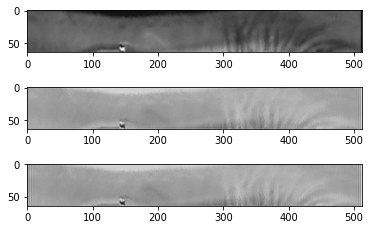

In [ ]:
fig, ax = plt.subplots(3,1)
ax[0].imshow(normalized, cmap = 'gray')
ax[1].imshow(filter1, cmap = 'gray')
ax[2].imshow(filter2, cmap = 'gray')

In [ ]:
def get_feature_vector(filtered_1, filtered_2):
    """As the paper denotes, this method generate the feature vector
    based on the two filtered image.
    :param filtered_1: the filtered image 1
    :param filtered_2: the filtered image 2
    :return: the feature vector
    :rtype: ndarray
    """

    blocks_1 = view_as_blocks(filtered_1, block_shape=(8, 8)).reshape([-1, 64])
    blocks_2 = view_as_blocks(filtered_2, block_shape=(8, 8)).reshape([-1, 64])

    def mad(array, axis):
        return np.mean(np.abs(array - np.mean(array, axis, keepdims=True)), axis)

    m_1 = blocks_1.mean(axis=-1)
    m_2 = blocks_2.mean(axis=-1)
    mad_1 = mad(blocks_1, axis=-1)
    mad_2 = mad(blocks_2, axis=-1)

    #     feature_vector = np.concatenate([np.stack([m_1, mad_1], axis=1).reshape([-1]),
    #                                     np.stack([m_2, mad_2], axis=1).reshape([-1])])
    feature_vector = np.stack([m_1, mad_1, m_2, mad_2], axis=1).reshape([-1])

    return feature_vector

In [ ]:
def getBitBlocks(filtered, size = 8):
    blocks = view_as_blocks(filtered, block_shape = (size,size)).reshape([-1,size**2])
    blocks = np.mean(blocks, axis = -1) - np.mean(filtered)
    return np.maximum(np.sign(blocks), 0)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(32, 16)


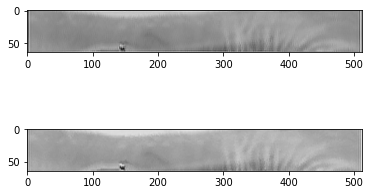

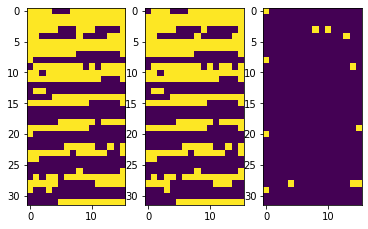

In [ ]:
filter1, filter2 = defined_gabor(normalized, 0.6, 3.0, 1.5)
#filter2, _ = defined_gabor(normalized, 0.05, 4.5, 1.5)

bitblock1 = getBitBlocks(filter1, size = 8)
bitblock2 = getBitBlocks(filter2, size = 8)
bitblock1 = bitblock1.reshape(bitblock1.shape[0]//16, 16)
bitblock2 = bitblock2.reshape(bitblock2.shape[0]//16, 16)
fig, ax = plt.subplots(2,1)
ax[0].imshow(filter1, cmap = 'gray')
ax[1].imshow(filter2, cmap = 'gray')
fig, ax = plt.subplots(1,3)
ax[0].imshow(bitblock1)
ax[1].imshow(bitblock2)
ax[2].imshow(np.abs(bitblock1 - bitblock2))

print(bitblock1.shape)


(64, 512)
(2048,)
[22.52458259  3.0920034  56.82368295 ...  4.86035634 51.07536436
  3.06556529]


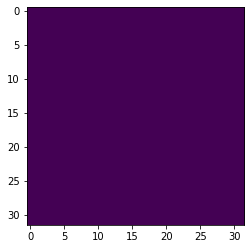

In [ ]:
features = get_feature_vector(filter1, filter2)
print(filter1.shape)
print(features.shape)
print(features)
plt.imshow(np.sign(features[:1024].reshape(32, 32)))

In [ ]:
gaborKernelOutput = defined_gabor_kernel(0.5, 3, 1.5)
print(gaborKernelOutput.shape)

(11, 19)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2b1844f8-cb52-40ca-a2fc-47a4d3e53a58' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>